# Solve viscous Burgers equation with ODE-ELM to show that it fails!

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import BurgersSolver
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.io
from matplotlib import ticker
import time
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'jet'

### Load data and reference solution

In [2]:
# Load and visualize data
data = scipy.io.loadmat('../../data/burgers_shock.mat')
t_eval = data['t'].flatten()[:,None]
x_eval = data['x'].flatten()[:,None]
u_exact = np.real(data['usol']).T
X, T = np.meshgrid(x_eval,t_eval)
X_ = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Set ground truth
u_true = u_exact.flatten()[:,None]              

### Problem setup

In [3]:
# initial condition
def u0(x):
    return -1 * np.sin(np.pi * x)

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# boundary condition
boundary_condition = "zero dirichlet" # 

# Domain information and spacial points for the first time-block
n_points_1d = 4000 # No. of points in space
x_lim = [-1, 1] # Domain range

# Interior points
rng = np.random.default_rng(seed=123)
x_space = rng.uniform(x_lim[0], x_lim[1], n_points_1d).reshape((-1, 1)) 
x_space_inner = x_space[1:-1]
interior_points = x_space_inner

# Boundary points (excluding corners)
left = x_lim[0]
right = x_lim[1]
boundary_points = np.row_stack([left, right])

### Train and evaluate ODE-ELM network

In [4]:
# Hyper-parameters
n_sample = 6000 # No. of sampling points (for computing gradients)
n_col = 3000 # No. of collocation points (to be re-sampled)
width = 2000 # Width
reg_const = 1e-7 # Regularization constant
svd_cutoff = 1e-10 # SVD threshold
seeds = [1, 2, 3] # Seeds (to compute mean errors)
time_blocks = 1 # Number of time-blocks for smapling
info = [] # List to store errors and time measurements

# Compute prob. distribution for (re)-sampling collocation points
def collocation_points_probabilities(df_dx):
    gradients = np.abs(df_dx)
    gradients = gradients + 0.05 * np.max(gradients)
    return gradients/np.sum(gradients)

# Points where gradient of the solution at the end of a time-block is computed
sample_test_points = np.sort(rng.uniform(x_lim[0] + 1e-4, x_lim[1] - 1e-4, n_sample)).reshape((-1, 1)) # This does not include boundary points

# Domain
domain = Domain(
    interior_points=interior_points,
    boundary_points=boundary_points,
    sample_points = sample_test_points
)

# Parameter sampler for sampling of weights and biases using data-agnostic distribution
def parameter_sampler_uniform(x, y, rng):
    """
        returns: weights, biases, idx_from, idx_to
    """
    n_dim = 1
    x_left = -3
    x_right = 3
    # Sample weights from a normal distribution
    weights = rng.normal(size=(n_dim, width)) #rng.uniform(x_left, x_right, size=(n_dim, n_OBF))
    # Sample biases from a uniform distribution
    biases = rng.uniform(x_left, x_right, size=(1, width))
    idx_from = np.arange(width)
    idx_to = np.arange(width)
    return weights, biases, idx_from, idx_to

# Loop over different seeds
rel_err_elm = np.ones((len(seeds), ))
time_elm = np.ones((len(seeds), ))
rmse_elm = np.ones((len(seeds), ))
j = 0

# Loop over different seeds
for seed in seeds: # Run for 3 seeds 
    # ODE-ELM network ansatz                     
    ansatz_elm = BasicAnsatz(
        n_neurons=width,
        activation="tanh",
        random_state=seed,
        regularization_scale=reg_const,
        parameter_sampler = parameter_sampler_uniform  
    )
    # Burger solver
    burgers_solver_elm = BurgersSolver(
        domain=domain, 
        ansatz=ansatz_elm,
        u0=u0,
        boundary_condition=boundary_condition,
        forcing=forcing,
        regularization_scale=reg_const,
        c=(0.01/np.pi)
    )
    # ELM fit
    t_elm_start = time.time()
    sol_elm, solver_status_elm = burgers_solver_elm.fit_time_blocks(t_span=[0, np.max(t_eval)], rtol=1e-8, atol=1e-8, svd_cutoff=svd_cutoff, time_blocks=time_blocks, prob_distr_resampling = collocation_points_probabilities, n_col=n_col, outer_basis=False);
    t_elm_stop = time.time()
    time_elm[j] = t_elm_stop - t_elm_start
    # Evaluate ELM-ODE predictions
    u_elm = (burgers_solver_elm.evaluate_blocks(x_eval= x_eval, t_eval = t_eval, time_blocks = time_blocks, solver_status = solver_status_elm)).T
    # Compute metrics
    mse_elm = mean_squared_error(u_true, u_elm.flatten()[:,None])  # mean squared error
    rmse_elm[j] = np.sqrt(mse_elm)  # Root Mean Squared Error
    rel_err_elm[j] = np.linalg.norm(u_true-u_elm.flatten()[:,None], 2)/np.linalg.norm(u_true,2)
    print("rmse_elm, re_elm")
    print(rmse_elm[j], rmse_elm[j], rel_err_elm[j], rel_err_elm[j])
    j += 1

info.append(np.mean(time_elm))
info.append(np.mean(rmse_elm))
info.append(np.std(rmse_elm))
info.append(np.mean(rel_err_elm))
info.append(np.std(rel_err_elm))
print(info)


rmse_elm, re_elm
0.15175027104385325 0.15175027104385325 0.24701449544694037 0.24701449544694037
rmse_elm, re_elm
0.15173057852918842 0.15173057852918842 0.24698244056795698 0.24698244056795698
rmse_elm, re_elm
0.15243588299644448 0.15243588299644448 0.24813051381960463 0.24813051381960463
[6.187496344248454, 0.15197224418982871, 0.00032794070199099765, 0.24737581661150065, 0.0005338119430140186]


In [5]:
# Print errors and time measurements for Burgers with ODE-ELM
res = np.vstack(info).reshape(-1)

# Burgers time measurements
print('Burgers equation: Errors and time measurements using ode-elm')
print('training time for ode-elm = ', res[-5])
print('rmse ode-elm = ', res[-4], '+-', res[-3])
print('rel error ode-elm = ', res[-2], '+-', res[-1])

Burgers equation: Errors and time measurements using ode-elm
training time for ode-elm =  6.187496344248454
rmse ode-elm =  0.15197224418982871 +- 0.00032794070199099765
rel error ode-elm =  0.24737581661150065 +- 0.0005338119430140186


In [34]:
#np.shape(burgers_solver_elm.ansatz._model[0].transform(x_eval.reshape(-1,1))[:, ])
np.shape(burgers_solver_elm.ansatz._model[0].transform(x_eval.reshape(-1,1))[:, ])

(256, 2000)

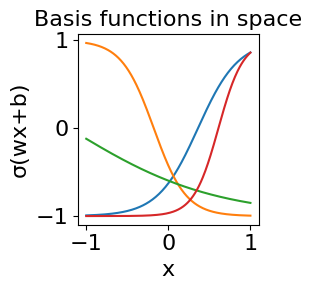

In [46]:
from swimnetworks import Dense

from sklearn.pipeline import Pipeline
random_seed_tanh = 1

basis_hidden_1 = Dense(
    layer_width=10,
    activation=np.tanh,
    parameter_sampler="tanh",
    sample_uniformly=True,
    random_seed=random_seed_tanh,
    prune_duplicates=True
)

x_lim = [0, 1]
n_points_grid = 50
n_points_quad = 200
grid_points = np.linspace(x_lim[0], x_lim[1], n_points_grid)
steps = [
    ("hidden-1", basis_hidden_1)
]
basis = Pipeline(steps=steps,verbose=False)
basis.fit(grid_points.reshape(-1,1), np.zeros((grid_points.shape[0],)))

fig, ax = plt.subplots(1,1,figsize=(3,3))
fontsize = 16
tanh_plot = burgers_solver_elm.ansatz._model[0].transform(x_eval.reshape(-1,1))
#for i in range(0,100,20):
#    if i == 0: pass
#    else:ax.plot(x_eval, tanh_plot[:,i]) #burgers_solver_swim.ansatz.activation(x_eval) # 


ax.plot(x_eval, tanh_plot[:,0])
ax.plot(x_eval, tanh_plot[:,1])
ax.plot(x_eval, tanh_plot[:,3])
ax.plot(x_eval, tanh_plot[:,9])
ax.set_title("Basis functions in space", fontsize=fontsize)
ax.set_ylabel("\u03C3(wx+b)", fontsize=fontsize)
ax.set_xlabel("x", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
fig.tight_layout()
fig.savefig("basis_functions.png")

In [56]:
np.shape(sol_elm.c_collection[0](t_eval.reshape(-1,)).T)

(100, 29)

In [72]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
i = 9
#ax.plot(t_eval, sol_elm[i,:])
ax.plot(t_eval, sol_elm.c_collection[0](t_eval.reshape(-1,))[4,:])
ax.plot(t_eval, sol_elm.c_collection[0](t_eval.reshape(-1,))[5,:])
ax.plot(t_eval, sol_elm.c_collection[0](t_eval.reshape(-1,))[3,:])
ax.plot(t_eval, sol_elm.c_collection[0](t_eval.reshape(-1,))[6,:])
#ax.plot(t_eval, sol_elm.c_collection[0](t_eval.reshape(-1,))[3,:])
#ax.plot(t_eval, sol_elm.c_collection[0](t_eval.reshape(-1,))[9,:])
ax.set_ylabel("c(t)", fontsize=fontsize)
ax.set_xlabel("t", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_title("Time-varying parameters", fontsize=fontsize)
fig.tight_layout()
fig.savefig("functions_coefficients.png")

Relative L2 error on the entire spatio-temporal domain: 2.481305e-01


C:\Users\chinm\AppData\Local\Temp\ipykernel_14040\841674867.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


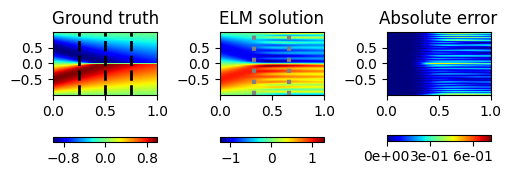

In [6]:
# True and model solutions
error_u = np.linalg.norm(u_true-u_elm.flatten()[:,None]  ,2)/np.linalg.norm(u_true,2)
print('Relative L2 error on the entire spatio-temporal domain: %e' % (error_u))

# visualize the solution
fig, ax = plt.subplots(1, 3, figsize=(5, 4), constrained_layout=True)
fontsize = 14
extent = [0 , 1, np.min(x_space), np.max(x_space)]
aspect = 0.3
sol_img1 = ax[0].imshow(u_exact.T, extent=extent, origin='lower', aspect=aspect)#, vmin=vlim[0], vmax=vlim[1]
sol_img2 = ax[1].imshow(u_elm.T, extent=extent, origin='lower', aspect=aspect)#, vmin=vlim[0], vmax=vlim[1]
error_img = ax[2].imshow(abs(u_elm - u_exact).T,  extent=extent, origin='lower', aspect=aspect)
ax[0].axvline(x=0.25, color='k', linestyle='--', linewidth=2)
ax[0].axvline(x=0.5, color='k', linestyle='--', linewidth=2)
ax[0].axvline(x=0.75, color='k', linestyle='--', linewidth=2)
ax[1].axvline(x=0.33, color='gray', linestyle='dotted', linewidth=3)
ax[1].axvline(x=0.66, color='gray', linestyle='dotted', linewidth=3)
cbar_true = fig.colorbar(sol_img1, ax=ax[0], location='bottom')
cbar_elm = fig.colorbar(sol_img2, ax=ax[1], location='bottom')
cbar_err = fig.colorbar(error_img, ax=ax[2], location='bottom', format='%.0e', fraction=0.046)

tick_locator_err = ticker.MaxNLocator(nbins=2)
cbar_err.locator = tick_locator_err
cbar_err.update_ticks()

tick_locator_elm = ticker.MaxNLocator(nbins=2)
cbar_elm.locator = tick_locator_elm
cbar_elm.update_ticks()

tick_locator_true = ticker.MaxNLocator(nbins=2)
cbar_true.locator = tick_locator_true
cbar_true.update_ticks()

ax[0].set_title('Ground truth')
ax[1].set_title('ELM solution')
ax[2].set_title('Absolute error')
fig.savefig("burgers_elm_ode_1.pdf")

fig, ax = plt.subplots(1, 3, figsize=(6,3), constrained_layout=True)
ax[0].plot(x_eval,u_exact[25,:], 'b-', linewidth = 2, label = 'Ground truth')       
ax[0].plot(x_eval,u_elm[25,:], 'r--', linewidth = 2, label = 'ELM-ODE (resampling)')
ax[0].set_xlabel('$x$', fontsize = 14)
ax[0].set_ylabel('$u(t,x)$', fontsize = 14)    
ax[0].set_title('$t = 0.25$', fontsize = 14)
ax[0].axis('square')
ax[0].set_xlim([-1.1,1.1])
ax[0].set_ylim([-1.1,1.1])
    
ax[1].plot(x_eval,u_exact[50,:], 'b-', linewidth = 2, label = 'Ground truth')       
ax[1].plot(x_eval,u_elm[50,:], 'r--', linewidth = 2, label = 'ELM-ODE (resampling)')
ax[1].set_xlabel('$x$', fontsize = 14)
ax[1].set_ylabel('$u(t,x)$', fontsize = 14)
ax[1].axis('square')
ax[1].set_xlim([-1.1,1.1])
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('$t = 0.50$', fontsize = 14)
    
ax[2].plot(x_eval,u_exact[75,:], 'b-', linewidth = 2, label = 'Ground truth')       
ax[2].plot(x_eval,u_elm[75,:], 'r--', linewidth = 2, label = 'ELM-ODE (resampling)')
ax[2].set_xlabel('$x$', fontsize = 14)
ax[2].set_ylabel('$u(t,x)$', fontsize = 14)
ax[2].axis('square')
ax[2].set_xlim([-1.1,1.1])
ax[2].set_ylim([-1.1,1.1])    
ax[2].set_title('$t = 0.75$', fontsize = 14)

# Create a single legend for all plots
fig.legend(*ax[1].get_legend_handles_labels(),loc='upper center', ncol=2, fontsize = 12, frameon=False)
fig.tight_layout()
fig.savefig("burgers_elm_ode_2.pdf", bbox_inches='tight')
    